# Clase 06 - Analisis y visualizacion: Establecimientos Educacionales

Profesor: **Fernando Becerra**, f.becerra@udd.cl, [www.fernandobecerra.com](www.fernandobecerra.com)

En esta clase analizaremos un caso de estudio de comienzo a fin, en el cual la idea es explorar los dats a través de la visualización de información para poder delinear una narrativa. En particular, analizaremos datos de los establedicmientos educacionales de la Región Metropolitana, aunque la aplicación del análisis no tiene porqué esta acotado a esa área.

Este ejercicio fue inspirado por una visualización que vi en [Twitter](https://twitter.com/jcovarrubia/status/1539440850257727489). Recuerden que siempre es bueno seguir gente que trabaje en datos y estar atento a lo que ell@s están haciendo. En nuestro caso no haremos exactamente el mismo proceso, sino que lo complementaremos con otras bases de datos para hacer un análisis más completo.

Lo primero es lo primero: importar lo típico

In [53]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Como dice el tuit, los datos son sacados del [portal de datos abiertos del Ministerio de Educación](https://datosabiertos.mineduc.cl).  Si nos vamos a "Estudiantes y Párvulos" y después ["Matrícula por estudiante"](https://datosabiertos.mineduc.cl/matricula-por-estudiante-2/), podemos acceder al archivo en formato `zip`. Este archivo incluye documentos de texto que nos ayudan con los nombres de las columnas y los valores que cada una puede tomar.

A nosotr@s nos interesa cargar el archivos `csv` que viene dentro y empezar a ver qué información tiene.

In [54]:
#!ls ../../datos/educacion/Matricula-por-estudiante-2021/20210913_Matrícula_unica_2021_20210430_WEB.CSV

In [55]:
df = pd.read_csv('../datos/educacion/Matricula-por-estudiante-2021/20210913_Matrícula_unica_2021_20210430_WEB.CSV',
                 sep=';',
                 low_memory=False)
df.head()


,AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,FEC_NAC_ALU,EDAD_ALU,COD_REG_ALU,COD_COM_ALU,NOM_COM_ALU,COD_SEC,COD_ESPE,COD_RAMA,COD_MEN,ENS
0,2021,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,196703,54,15,15101,ARICA,410,41001,400,0,13
1,2021,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,199607,24,15,15101,ARICA,410,41001,400,0,13
2,2021,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,196911,51,15,15101,ARICA,410,41001,400,0,13
3,2021,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,197802,43,1,1101,IQUIQUE,410,41001,400,0,13
4,2021,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,199509,25,15,15101,ARICA,410,41001,400,0,13


Lo primero que haremos para hacer el análisis un poco más fácil, es restringir el análisis a la Región Metropolitana. Para eso, eligiremos sólo los establecimientos y alumn@s que se ubican en dicha región, y filtraremos los datos en base a eso.

In [56]:
df_rm = df[(df['COD_REG_RBD'] == 13) & (df['COD_REG_ALU'] == 13)].reset_index()
df_rm.head()
# df_rm = df[(df['COD_PRO_RBD'] == 131) & (df['COD_COM_ALU'].isin(comunas_santiago))].reset_index()

,index,AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,...,FEC_NAC_ALU,EDAD_ALU,COD_REG_ALU,COD_COM_ALU,NOM_COM_ALU,COD_SEC,COD_ESPE,COD_RAMA,COD_MEN,ENS
0,1324745,2021,8485,9,LICEO INSTITUTO NACIONAL,13,RM,131,13101,SANTIAGO,...,200811,12,13,13101,SANTIAGO,0,0,0,0,3
1,1324746,2021,8485,9,LICEO INSTITUTO NACIONAL,13,RM,131,13101,SANTIAGO,...,200812,12,13,13104,CONCHALÍ,0,0,0,0,3
2,1324747,2021,8485,9,LICEO INSTITUTO NACIONAL,13,RM,131,13101,SANTIAGO,...,200902,12,13,13101,SANTIAGO,0,0,0,0,3
3,1324748,2021,8485,9,LICEO INSTITUTO NACIONAL,13,RM,131,13101,SANTIAGO,...,200807,12,13,13102,CERRILLOS,0,0,0,0,3
4,1324749,2021,8485,9,LICEO INSTITUTO NACIONAL,13,RM,131,13101,SANTIAGO,...,200801,13,13,13120,ÑUÑOA,0,0,0,0,3


Para empezar a familiarizarnos con los datos y con ayuda de los documentos adjuntos, empezamos a ver de qué se trata cada columna y como vamos a trabajar con ellas. Por ejemplo, sería bueno saber el número total de establecimientos luego de haberlos filtrados.

In [57]:
len(pd.unique(df_rm['RBD']))

2918

## Parte 1: Movimiento general de la matrícula en la Región Metropolitana

Para comenzar el análisis, nos inspiraremos en un ejemplo visto en las clases anteriores: la encuesta origen-destino. Veremos la movilidad de cada estudiante en base a la comuna donde vive y la comuna donde estudia. Para eso reutilizaremos código de ese ejemplo para calcularel flujo desde una comuna a otra,

In [58]:
from sklearn.preprocessing import normalize

def normalize_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def normalize_columns(df):
    df = pd.DataFrame(normalize(df, norm='l1', axis=0), index=df.index, columns=df.columns)
    return df

In [59]:
flujos = (
    df_rm.groupby(['NOM_COM_RBD', 'NOM_COM_ALU'])
          .agg(n_matriculas=('NOM_COM_ALU', 'count'))
          ['n_matriculas'].unstack(fill_value=0)
          .pipe(normalize_rows)
)
flujos.head()

NOM_COM_ALU,ALHUÉ,BUIN,CALERA DE TANGO,CERRILLOS,CERRO NAVIA,COLINA,CONCHALÍ,CURACAVÍ,EL BOSQUE,EL MONTE,...,SAN JOAQUÍN,SAN JOSÉ DE MAIPO,SAN MIGUEL,SAN PEDRO,SAN RAMÓN,SANTIAGO,TALAGANTE,TILTIL,VITACURA,ÑUÑOA
NOM_COM_RBD,,,,,,,,,,,,,,,,,,,,,
ALHUÉ,0.950326,0.000814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000814,0.000000,0.023616,0.000000,0.000000,0.000000,0.000000
BUIN,0.000546,0.823562,0.002595,0.000819,0.001912,0.000501,0.000910,0.000228,0.004324,0.000637,...,0.001639,0.000000,0.003551,0.000000,0.001229,0.021258,0.001866,0.000182,0.000819,0.002413
CALERA DE TANGO,0.000000,0.012522,0.616452,0.007128,0.000771,0.001926,0.000771,0.000385,0.006165,0.000963,...,0.001156,0.000385,0.004431,0.000000,0.001926,0.025043,0.030052,0.000000,0.000963,0.003082
CERRILLOS,0.000079,0.000475,0.000871,0.632816,0.002533,0.000792,0.001029,0.000158,0.003404,0.000871,...,0.002137,0.000000,0.002533,0.000079,0.001504,0.058335,0.000950,0.000079,0.000079,0.001187
CERRO NAVIA,0.000000,0.000356,0.000119,0.002436,0.751307,0.001485,0.001366,0.000594,0.001961,0.000416,...,0.001069,0.000000,0.000535,0.000000,0.000535,0.045449,0.000059,0.000119,0.000059,0.000535


Una de mis visualizaciones favoritas es el heat map, por lo que ocuparemos ese gráfico para visualizar esta red.

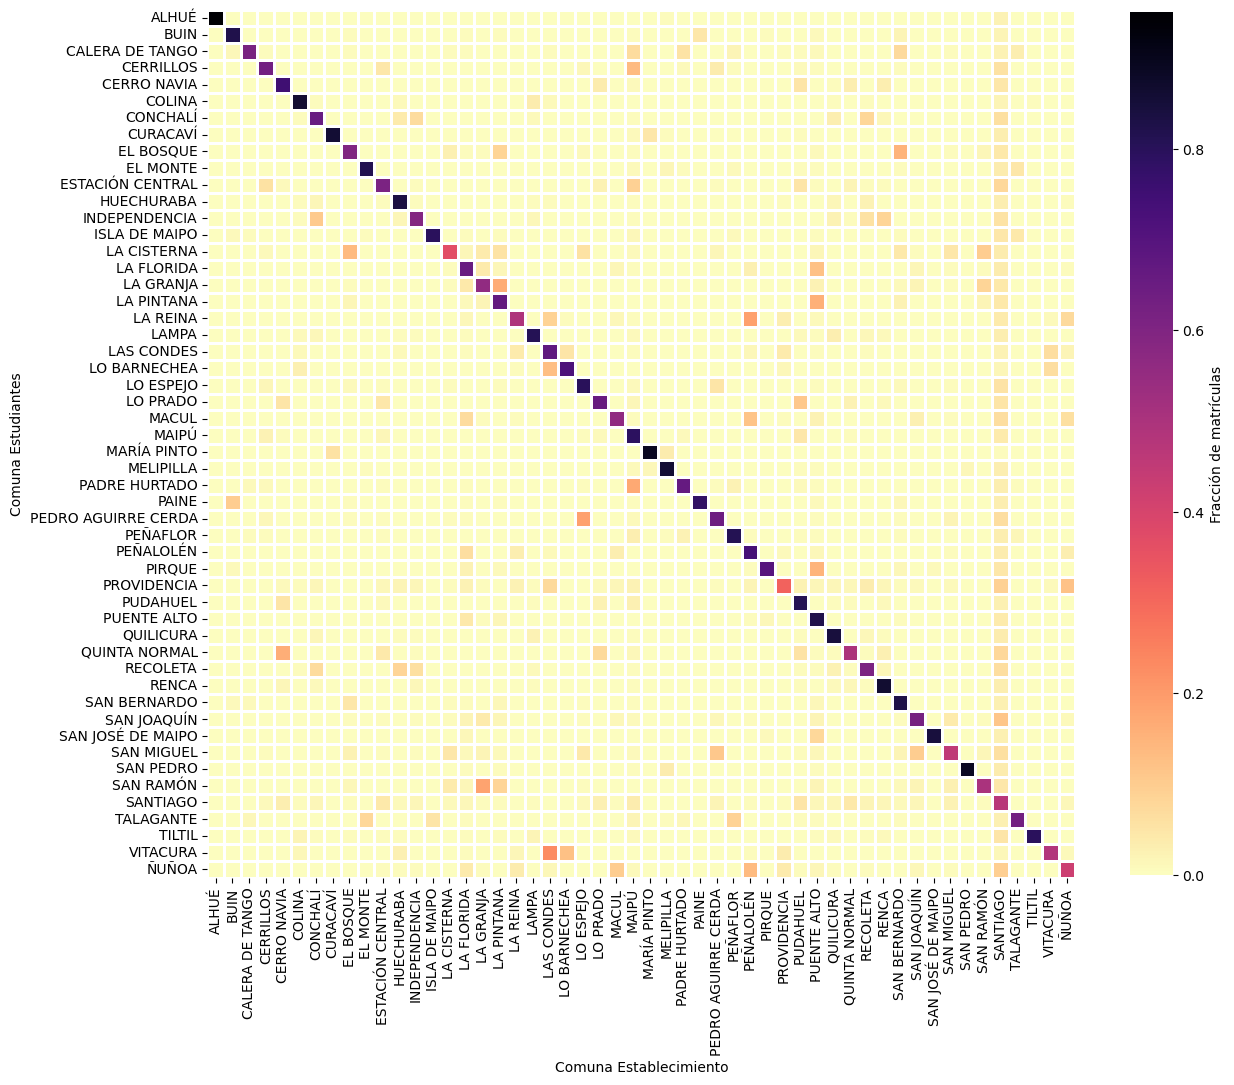

In [60]:
plt.figure(figsize=(14, 14))
sns.heatmap(flujos, cmap='magma_r', square=True, linewidths=1, 
            cbar_kws={'shrink': 0.8, 'label': 'Fracción de matrículas'})
plt.xlabel('Comuna Establecimiento')
plt.ylabel('Comuna Estudiantes')
plt.show()

## Parte 2: Origen de la matrícula de cada establecimiento

La visualización anterior nos da una idea general de como se mueven los estudiantes desde una comuna a otra, pero ahora queremos ir más al detalle. Comenzar con una vista general para luego ir a lo específico es una buena forma de hacer la información más digerible.

En este paso calcularemos la cantidad de matrículas de cada colegio por comuna de origen. 

In [61]:
establecimientos = (
    df_rm.groupby(['RBD','NOM_RBD', 'COD_COM_ALU'])
        .agg(n_matriculas=('COD_COM_ALU', 'count'))
)

establecimientos.head()

n_matriculas
RBD  NOM_RBD                  COD_COM_ALU              
8485 LICEO INSTITUTO NACIONAL 13101                 369
                              13102                  34
                              13103                 130
                              13104                 151
                              13105                  66

Para hacerlo comparables entre distintos establecimientos educacionales, lo transformaremos a porcentaje de matrícula.

In [62]:
establecimientos['n_percent'] = establecimientos['n_matriculas'] / establecimientos.groupby('NOM_RBD')['n_matriculas'].transform('sum')
establecimientos.head(3)

n_matriculas  n_percent
RBD  NOM_RBD                  COD_COM_ALU                         
8485 LICEO INSTITUTO NACIONAL 13101                 369   0.102159
                              13102                  34   0.009413
                              13103                 130   0.035991

In [63]:
establecimientos = establecimientos.reset_index()

¡Ahora es momento de empezar a mapear! Para eso importamos `geopandas`

In [64]:
import geopandas as gpd

Y cargamos los arhivos `shp` sacados desde la [Biblioteca del Congreso Nacional](https://www.bcn.cl/siit/mapas_vectoriales/index_html).

In [65]:
comunas = gpd.read_file('../datos/bcn/Comunas/comunas.shp')
comunas.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."


Exploramos las regiones disponible para poder filtrarlas

In [66]:
pd.unique(comunas['Region'])

array(["Región del Libertador Bernardo O'Higgins",
       'Región de La Araucanía', 'Región Metropolitana de Santiago',
       'Región de Los Lagos', 'Región de Los Ríos', 'Región del Maule',
       'Región de Coquimbo', 'Región de Magallanes y Antártica Chilena',
       'Zona sin demarcar', 'Región de Valparaíso', 'Región del Bío-Bío',
       'Región de Aysén del Gral.Ibañez del Campo', 'Región de Tarapacá',
       'Región de Arica y Parinacota', 'Región de Antofagasta',
       'Región de Ñuble', 'Región de Atacama'], dtype=object)

Y ahora filtramos los datos

In [67]:
comunas_rm = comunas[comunas['Region'] == 'Región Metropolitana de Santiago'].reset_index()
comunas_rm.head()

,index,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,26,330,13987.326781,10,7,13129,13,1.424341e+07,16812.167615,Región Metropolitana de Santiago,San Joaquín,Santiago,"POLYGON ((-7861762.687 -3958307.095, -7861708...."
1,36,331,13311.641304,13,7,13130,13,1.389538e+07,15988.816037,Región Metropolitana de Santiago,San Miguel,Santiago,"POLYGON ((-7863229.775 -3964360.652, -7863319...."
2,47,332,11733.486710,13,7,13131,13,9.056280e+06,14061.528858,Región Metropolitana de Santiago,San Ramón,Santiago,"POLYGON ((-7863398.118 -3964354.273, -7863319...."
3,57,309,11488.695747,9,7,13108,13,1.068637e+07,14088.417488,Región Metropolitana de Santiago,Independencia,Santiago,"POLYGON ((-7865631.125 -3948404.075, -7865643...."
4,61,310,12797.595762,13,7,13109,13,1.454185e+07,15442.412755,Región Metropolitana de Santiago,La Cisterna,Santiago,"POLYGON ((-7865040.615 -3968217.521, -7865077...."


Para ver que todo esté en orden, lo vamos a graficar primero.

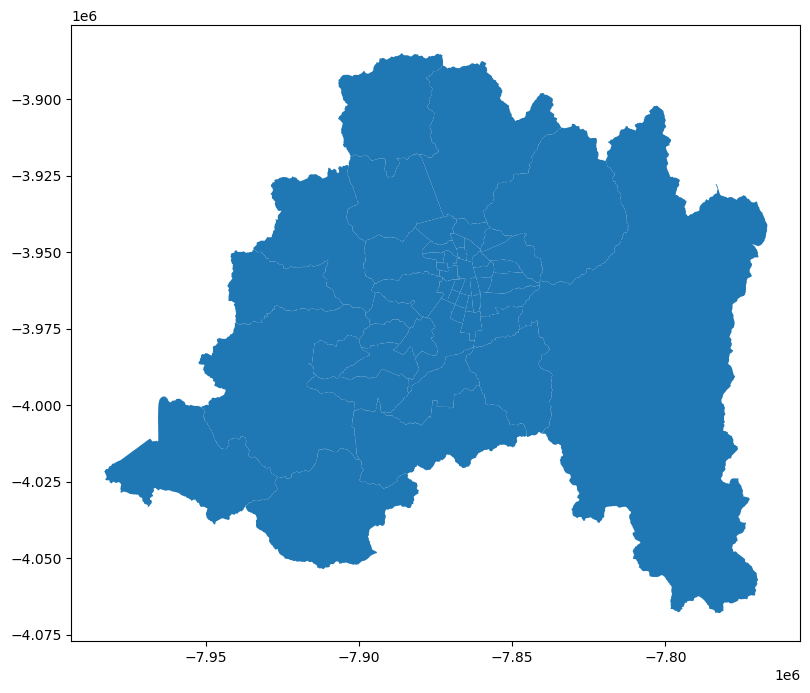

In [68]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

comunas_rm.plot(ax=ax)

plt.show()

Ahora definiremos una función que reciba el nombre de un establecimiento y grafique el porcentaje de estudiantes matriculados por comuna.

In [69]:
def plot_establecimiento(establecimiento, ax):

    filtered_df = establecimientos[establecimientos['NOM_RBD'] == establecimiento]
    establecimiento_df = (
        pd.merge(comunas_rm,
            filtered_df.set_index('COD_COM_ALU'),
            left_on='cod_comuna',
            right_index=True,
            how='left')
        .fillna(0)
    )

    establecimiento_df.plot(ax=ax,
                            column='n_percent', 
                            cmap='BuPu',
                            linewidth=0.2,)
    
    ax.set_title(establecimiento)


Ahora veamos que establecimientos están disponibles.

In [70]:
print(list(pd.unique(establecimientos['NOM_RBD'])))

['LICEO INSTITUTO NACIONAL', 'LICEO JAVIERA CARRERA', 'LICEO N° 4 BICENTENARIO ISAURA DINATOR', 'LICEO BICENTENARIO TERESA PRATS', 'LICEO NRO 2 MIGUEL LUIS AMUNATEGUI', 'LICEO DE APLICACION RECTOR JORGE E SCHNE', 'LICEO MANUEL BARROS BORGONO', 'LICEO A-1 VALENTIN LETELIER', 'LICEO CONFEDERACION SUIZA', 'LICEO JOSÉ DE SAN MARTIN', 'LICEO GABRIELA MISTRAL', 'LICEO DARIO SALAS', 'INTERNADO NACIONAL BARROS ARANA', 'LICEO INDUSTRIAL ELIODORO GARCIA ZEGERS', 'LICEO POLITEC. PDTE. GABRIEL GONZALEZ VIDELA', 'LICEO COMERCIAL LUIS CORREA PRIETO', 'INST.SUP.DE COMERCIO EDUARDO FREI M.', 'LICEO TECNICO A N° 27 CLELIA CLAVEL DINAT', 'LICEO POLIVALENTE A-28 EMILIA TORO DE BAL', 'INSTITUTO COMERCIAL ELIODORO DOMINGUEZ DOMINGUEZ', 'LICEO COMERCIAL JOAQUIN VERA MORALES', 'LICEO POLIVALENTE JUAN A.RIOS', 'LICEO PAULA JARAQUEMADA', 'LICEO EXPERIMENTAL ARTISTICO B-65', 'ESC. BAS. REPUBLICA ORIENTAL DE URUGUAY', 'LICEO MULTIGENERO DOCTORA ELOISA DIAZ INZUNZA', 'ESCUELA BASICA CORNELIA OLIVARES', 'LICEO EST

Empecemos a probar algunos.

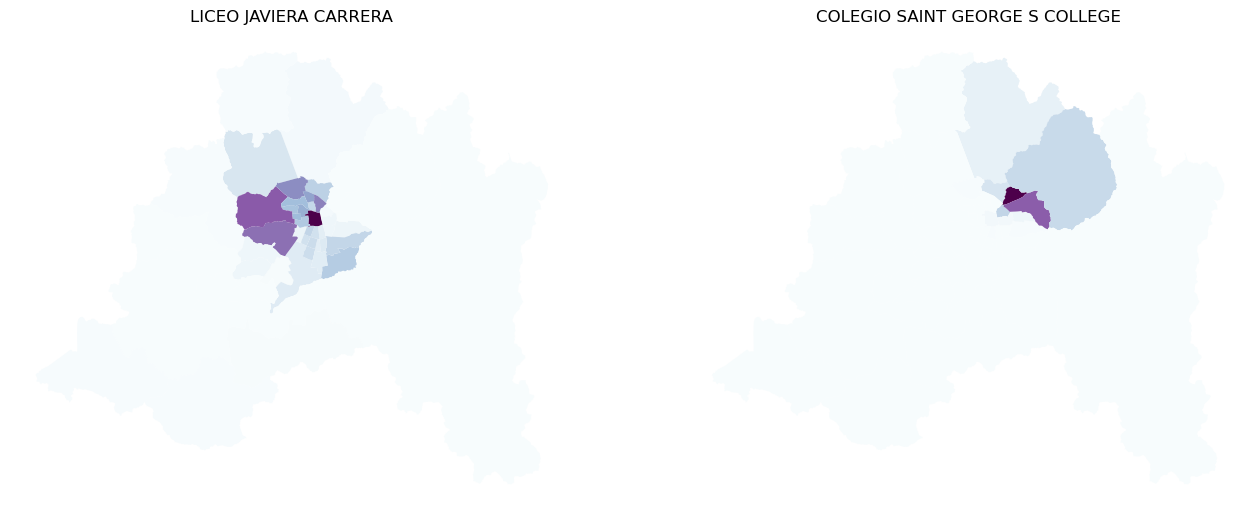

In [71]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

plot_establecimiento('LICEO JAVIERA CARRERA', ax[0])
plot_establecimiento('COLEGIO SAINT GEORGE S COLLEGE', ax[1])

ax[0].set_axis_off()
ax[1].set_axis_off()

# ax[0].set_xlim(-7.92e6, -7.83e6)
# ax[0].set_ylim(-4e6, -3.91e6)
# ax[1].set_xlim(-7.92e6, -7.83e6)
# ax[1].set_ylim(-4e6, -3.91e6)

plt.show()

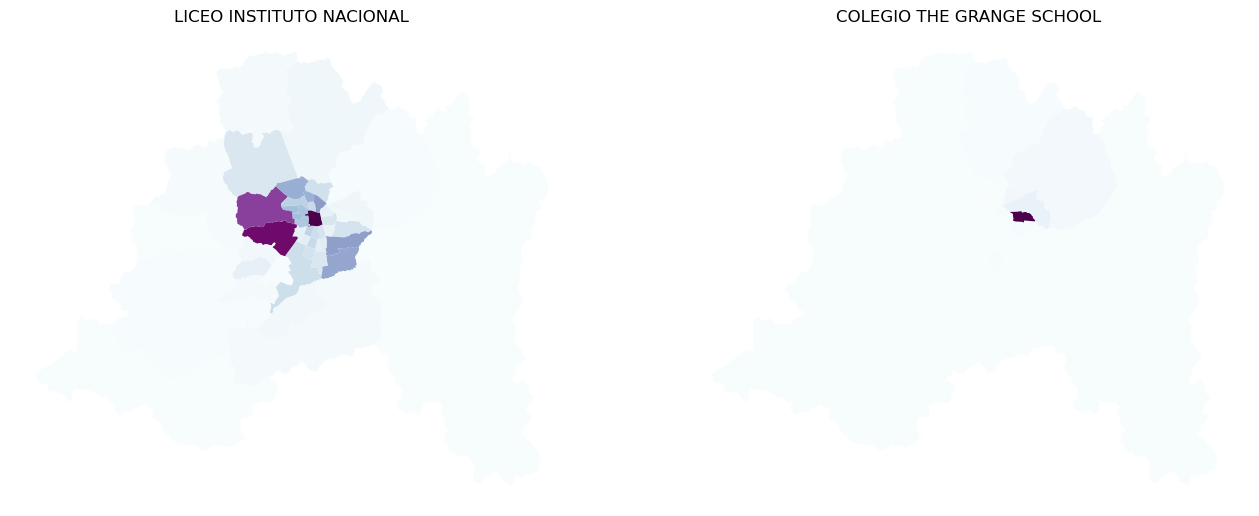

In [72]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

plot_establecimiento('LICEO INSTITUTO NACIONAL', ax[0])
plot_establecimiento('COLEGIO THE GRANGE SCHOOL', ax[1])

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.show()

Este tipo de visualización tiene mucho potencial una vez que se identifiquen establecimientos interesantes. En principio se podría hacer una infografía o un póster usando *small multiples*, pero eso queda como trabajo extra.

## Parte 3: Creando un índice de pobreza por establecimiento

Ahora que tenemos el porcentaje de estudiantes que vienen de distintas comunas, podríamos ocupar datos comunales para derivar otros indicadores. Por ejemplo, podríamos buscar datos de tasa de pobreza por comuna y ver cómo usar es para caracterizar la población de cada establecimiento educacional.

Los datos de tasas de pobreza comunales pueden ser sacados de la [Encuesta Casen](http://observatorio.ministeriodesarrollosocial.gob.cl/encuesta-casen-en-pandemia-2020).

In [73]:
casen = pd.read_excel('../datos/casen/Estimaciones_de_Tasa_de_Pobreza_por_Ingresos_por_Comunas_2020.xlsx', skiprows=2)
casen.head()

,Código,Región,Nombre comuna,Número de personas según proyecciones de población (*),Número de personas en situación de pobreza por ingresos (**),Porcentaje de personas en situación de pobreza por ingresos 2020,Límite inferior,Límite superior,Presencia de la comuna en la muestra Casen,Tipo de estimación SAE (***)
0,15101,XV de Arica y Parinacota,Arica,248820.0,29253.933643,0.117571,0.102854,0.132287,Si,Directa y Sintética (Fay-Herriot)
1,15102,XV de Arica y Parinacota,Camarones,1236.0,281.731865,0.227938,0.156078,0.299798,Si,Sintética
2,15201,XV de Arica y Parinacota,Putre,2124.0,434.211318,0.204431,0.143767,0.265095,Si,Sintética
3,15202,XV de Arica y Parinacota,General Lagos,674.0,173.837157,0.257919,0.185909,0.329928,No,Sintética
4,1101,I de Tarapacá,Iquique,224971.0,27794.643614,0.123548,0.106849,0.140246,Si,Directa y Sintética (Fay-Herriot)


Filtramos sólo los datos de la Región Metropolitana.

In [74]:
casen_rm = casen[casen['Región'] == 'XIII Metropolitana de Santiago'].reset_index()
casen_rm.head()

,index,Código,Región,Nombre comuna,Número de personas según proyecciones de población (*),Número de personas en situación de pobreza por ingresos (**),Porcentaje de personas en situación de pobreza por ingresos 2020,Límite inferior,Límite superior,Presencia de la comuna en la muestra Casen,Tipo de estimación SAE (***)
0,82,13101,XIII Metropolitana de Santiago,Santiago,508785.0,42878.203660,0.084276,0.062351,0.106200,Si,Directa y Sintética (Fay-Herriot)
1,83,13102,XIII Metropolitana de Santiago,Cerrillos,89174.0,8020.140239,0.089938,0.061526,0.118350,Si,Directa y Sintética (Fay-Herriot)
2,84,13103,XIII Metropolitana de Santiago,Cerro Navia,142391.0,18328.187345,0.128717,0.093194,0.164240,Si,Directa y Sintética (Fay-Herriot)
3,85,13104,XIII Metropolitana de Santiago,Conchalí,139274.0,17331.889326,0.124445,0.091285,0.157604,Si,Directa y Sintética (Fay-Herriot)
4,86,13105,XIII Metropolitana de Santiago,El Bosque,171889.0,21590.830268,0.125609,0.094112,0.157107,Si,Directa y Sintética (Fay-Herriot)


Aquí la idea es tener un indicador de situación socioeconómica por establecimiento educacional. Para eso, calcularemos un promedio usando como peso el porcentaje de estudiantes de esa comuna.

In [75]:
def weighted_mean(df, value='Porcentaje de personas en situación de pobreza por ingresos 2020', weight='n_percent'):
    weighted_sum = (df[value] * df[weight]).sum()
    return weighted_sum

Hay que tener cuidado como se manejan los datos para poder mezclarlos y hacer operaciones en ellos.

In [76]:
tasa_pobreza = (
    pd.merge(establecimientos,
             casen_rm.set_index('Código'),
             left_on='COD_COM_ALU',
             right_index=True)
    .groupby(['RBD'])
    .apply(weighted_mean)
    .reset_index()
)
tasa_pobreza.columns = ['RBD', 'TASA_POBREZA']
tasa_pobreza.head()

,RBD,TASA_POBREZA
0,8485,0.097376
1,8487,0.101343
2,8488,0.101713
3,8489,0.102680
4,8490,0.095742


Información adicional que nos va a servir en nuestro análisis es el tipo de subvención que tiene cada establecimiento: municipal, particular subvencionado o particular pagado. Por lo que agregamos esa columna a nuestro dataframe.

In [77]:
depe = (
    df_rm.groupby('RBD')
        .first()
        .reset_index()[['RBD', 'NOM_RBD', 'COD_DEPE2']]
)
depe.head()

,RBD,NOM_RBD,COD_DEPE2
0,8485,LICEO INSTITUTO NACIONAL,1
1,8487,LICEO JAVIERA CARRERA,1
2,8488,LICEO N° 4 BICENTENARIO ISAURA DINATOR,1
3,8489,LICEO BICENTENARIO TERESA PRATS,1
4,8490,LICEO NRO 2 MIGUEL LUIS AMUNATEGUI,1


Y lo mezclamos con nuestros datos

In [78]:
rbd_pobreza = tasa_pobreza.merge(depe)
rbd_pobreza.head()

,RBD,TASA_POBREZA,NOM_RBD,COD_DEPE2
0,8485,0.097376,LICEO INSTITUTO NACIONAL,1
1,8487,0.101343,LICEO JAVIERA CARRERA,1
2,8488,0.101713,LICEO N° 4 BICENTENARIO ISAURA DINATOR,1
3,8489,0.102680,LICEO BICENTENARIO TERESA PRATS,1
4,8490,0.095742,LICEO NRO 2 MIGUEL LUIS AMUNATEGUI,1


Ahora graficamos las distribuciones de los establecimientos en base al índice de pobreza que recién calculamos. Para hacer el análisis más interesante, lo dividiremos según el tipo de subvención que reciba el establecimiento.

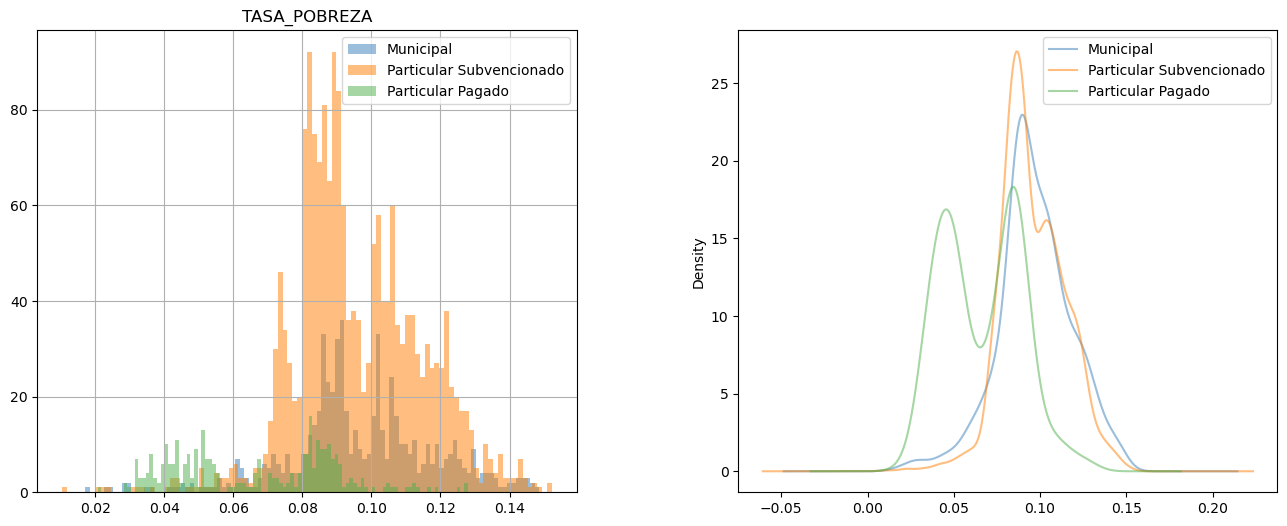

In [79]:
labels = ['Municipal', 'Particular Subvencionado', 'Particular Pagado']
colors = ['#377eb8', '#ff7f00', '#4daf4a']

fig, ax = plt.subplots(1,2,figsize=(16,6))

for depe in range(1, 4):
    filtered = rbd_pobreza[rbd_pobreza['COD_DEPE2'] == depe]
    filtered.hist(column='TASA_POBREZA', ax=ax[0], alpha=0.5, label=labels[depe-1], bins=100, color=colors[depe-1])
    
    filtered = rbd_pobreza[rbd_pobreza['COD_DEPE2'] == depe]
    filtered['TASA_POBREZA'].plot.kde(ax=ax[1], alpha=0.5, label=labels[depe-1], color=colors[depe-1])
    
ax[0].legend()
ax[1].legend()
plt.show()

Otra de mis visualizaciones favoritas para representar distribuciones es el `beeswarm`. Afortunadamente, `seaborn` trae una función que nos permite crearla de una forma sencilla.

d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carlos\AppData\Local\Temp\ipykernel_36536\2967464866.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[depe-1].set_yticklabels([labels[depe-1]])
d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', T

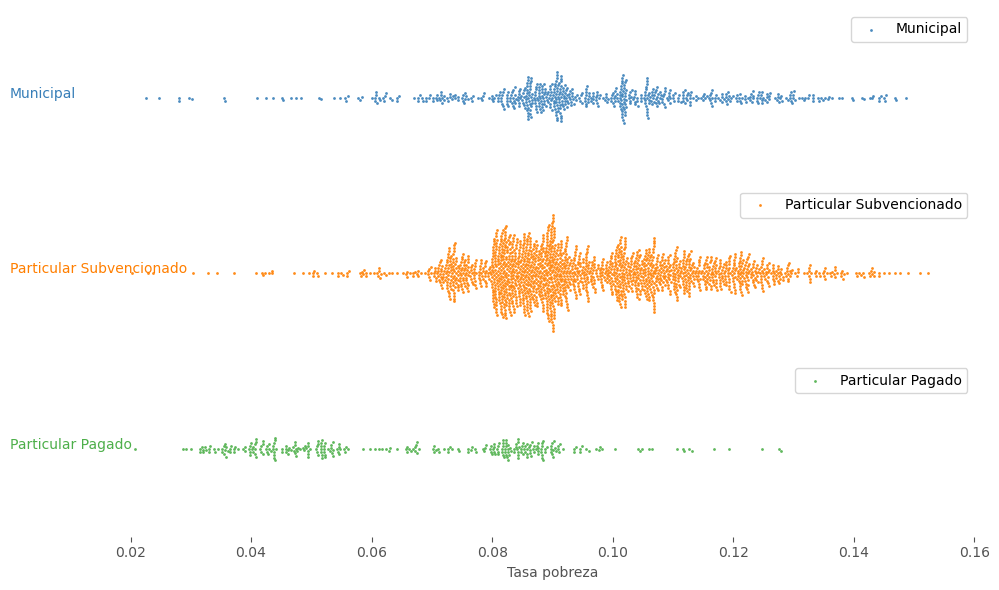

In [80]:
labels = ['Municipal', 'Particular Subvencionado', 'Particular Pagado']
colors = ['#377eb8', '#ff7f00', '#4daf4a']

fig, ax = plt.subplots(3,1,figsize=(10,6), sharex=True)

for depe in range(1, 4):
    filtered = rbd_pobreza[rbd_pobreza['COD_DEPE2'] == depe]
    sns.swarmplot(x = filtered['TASA_POBREZA'] , ax=ax[depe-1], alpha=0.9, label=labels[depe-1], size=2, color=colors[depe-1])
    
    ax[depe-1].set_xlim(0.02,0.16)
    ax[depe-1].set_yticklabels([labels[depe-1]])
    ax[depe-1].text(0, 0, labels[depe-1], color=colors[depe-1])

    if (depe == 3):
         for key, spine in ax[depe-1].spines.items():
             spine.set_visible(False)
         ax[depe-1].spines['left'].set_visible(False)
         ax[depe-1].spines['right'].set_visible(False)
         ax[depe-1].xaxis.label.set_color('#525252')
         ax[depe-1].tick_params(axis='x', colors='#525252')
         ax[depe-1].set_xlabel('Tasa pobreza')
         ax[depe-1].set_yticks([])
    else:
         ax[depe-1].set_axis_off()

# fig.suptitle('La mayoría de los colegios particulares subvencionados se enfocan en estudiantes de clase media y media-baja', x=0.005, y=0.98, ha='left')
fig.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

Encontrar los comandos correctos para borrar `ticks`, `ticklabels` y `spines` puede tomar tiempo, así que dejo [este enlace](https://stackabuse.com/matplotlib-turn-off-axis-spines-ticklabels-axislabels-grid/) que los puede ayudar a personalizar sus gráficos. Igual que en la parte anterior, hay mucho que se le puede agregar y mejorar a esta visualización, por lo que eso también queda como ejercicio para cada uno de ustedes.

## Parte 4: Comparación índice de pobreza con resultados SIMCE

Para poder comparar pobreza con resultados en pruebas estandarizadas, debemos cargar nuevos datos. Esta vez, los sacamos de [la base de datos del SIMCE](https://informacionestadistica.agenciaeducacion.cl/#/bases).

In [81]:
simce = pd.read_excel('../datos/educacion/Simce8b2019_publicas_web/Archivos XLS (XLSX)/simce8b2019_rbd.xlsx')
simce.head()

,agno,grado,rbd,dvrbd,nom_rbd,cod_reg_rbd,nom_reg_rbd,cod_pro_rbd,nom_pro_rbd,cod_com_rbd,...,siggru_soc8b_rbd,marca_lect8b_rbd,marca_mate8b_rbd,marca_soc8b_rbd,marcadif_lect8b_rbd,marcadif_mate8b_rbd,marcadif_soc8b_rbd,noaplica,fecha_bbdd,codigo_bbdd
0,2019,8b,5,1,JOVINA NARANJO FERNANDEZ,15,DE ARICA Y PARINACOTA,151,ARICA,15101,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
1,2019,8b,8,6,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,DE ARICA Y PARINACOTA,151,ARICA,15101,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
2,2019,8b,9,4,ESCUELA REPUBLICA DE ISRAEL,15,DE ARICA Y PARINACOTA,151,ARICA,15101,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
3,2019,8b,10,8,ESCUELA REPUBLICA DE FRANCIA,15,DE ARICA Y PARINACOTA,151,ARICA,15101,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
4,2019,8b,11,6,ESC. GRAL. PEDRO LAGOS MARCHANT,15,DE ARICA Y PARINACOTA,151,ARICA,15101,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2


Y filtramos sólo los establecimientos con los cuales hemos estado trabajando hasta el momento.

In [82]:
simce_rm = simce[simce['rbd'].isin(rbd_pobreza['RBD'])]
simce_rm.head()


,agno,grado,rbd,dvrbd,nom_rbd,cod_reg_rbd,nom_reg_rbd,cod_pro_rbd,nom_pro_rbd,cod_com_rbd,...,siggru_soc8b_rbd,marca_lect8b_rbd,marca_mate8b_rbd,marca_soc8b_rbd,marcadif_lect8b_rbd,marcadif_mate8b_rbd,marcadif_soc8b_rbd,noaplica,fecha_bbdd,codigo_bbdd
2961,2019,8b,8485,9,LICEO INSTITUTO NACIONAL,13,METROPOLITANA DE SANT,131,SANTI,13101,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
2962,2019,8b,8487,5,LICEO JAVIERA CARRERA,13,METROPOLITANA DE SANT,131,SANTI,13101,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
2963,2019,8b,8488,3,LICEO ISAURA DINATOR DE GUZMAN,13,METROPOLITANA DE SANT,131,SANTI,13101,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
2964,2019,8b,8489,1,LICEO BICENTENARIO TERESA PRATS,13,METROPOLITANA DE SANT,131,SANTI,13101,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2
2965,2019,8b,8490,5,LICEO NRO 2 MIGUEL LUIS AMUNATEGUI,13,METROPOLITANA DE SANT,131,SANTI,13101,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,20200807,final20200811v2


Exploramos las columnas disponibles para saber cuáles nos servirán.

In [83]:
simce_rm.columns

Index(['agno', 'grado', 'rbd', 'dvrbd', 'nom_rbd', 'cod_reg_rbd',
       'nom_reg_rbd', 'cod_pro_rbd', 'nom_pro_rbd', 'cod_com_rbd',
       'nom_com_rbd', 'cod_deprov_rbd', 'nom_deprov_rbd', 'cod_depe1',
       'cod_depe2', 'cod_grupo', 'cod_rural_rbd', 'nalu_lect8b_rbd',
       'nalu_mate8b_rbd', 'nalu_soc8b_rbd', 'prom_lect8b_rbd',
       'prom_mate8b_rbd', 'prom_soc8b_rbd', 'dif_lect8b_rbd', 'dif_mate8b_rbd',
       'dif_soc8b_rbd', 'difgru_lect8b_rbd', 'difgru_mate8b_rbd',
       'difgru_soc8b_rbd', 'sigdif_lect8b_rbd', 'sigdif_mate8b_rbd',
       'sigdif_soc8b_rbd', 'siggru_lect8b_rbd', 'siggru_mate8b_rbd',
       'siggru_soc8b_rbd', 'marca_lect8b_rbd', 'marca_mate8b_rbd',
       'marca_soc8b_rbd', 'marcadif_lect8b_rbd', 'marcadif_mate8b_rbd',
       'marcadif_soc8b_rbd', 'noaplica', 'fecha_bbdd', 'codigo_bbdd'],
      dtype='object')

Definimos las que tengan puntajes de las pruebas para usarlas después.

In [84]:
pruebas_simce = ['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']
simce_rm = simce_rm[['rbd'] + pruebas_simce]
simce_rm.columns = ['RBD'] + pruebas_simce
simce_rm.head()

,RBD,prom_lect8b_rbd,prom_soc8b_rbd,prom_mate8b_rbd
2961,8485,257.0,276.0,291.0
2962,8487,246.0,262.0,269.0
2963,8488,249.0,238.0,260.0
2964,8489,252.0,249.0,257.0
2965,8490,203.0,222.0,228.0


Los mezclamos con nuestro dataset

In [85]:
simce_pobreza = rbd_pobreza.merge(simce_rm)
simce_pobreza.head()

,RBD,TASA_POBREZA,NOM_RBD,COD_DEPE2,prom_lect8b_rbd,prom_soc8b_rbd,prom_mate8b_rbd
0,8485,0.097376,LICEO INSTITUTO NACIONAL,1,257.0,276.0,291.0
1,8487,0.101343,LICEO JAVIERA CARRERA,1,246.0,262.0,269.0
2,8488,0.101713,LICEO N° 4 BICENTENARIO ISAURA DINATOR,1,249.0,238.0,260.0
3,8489,0.102680,LICEO BICENTENARIO TERESA PRATS,1,252.0,249.0,257.0
4,8490,0.095742,LICEO NRO 2 MIGUEL LUIS AMUNATEGUI,1,203.0,222.0,228.0


Y graficamos para ver que relación hay entre esas variables

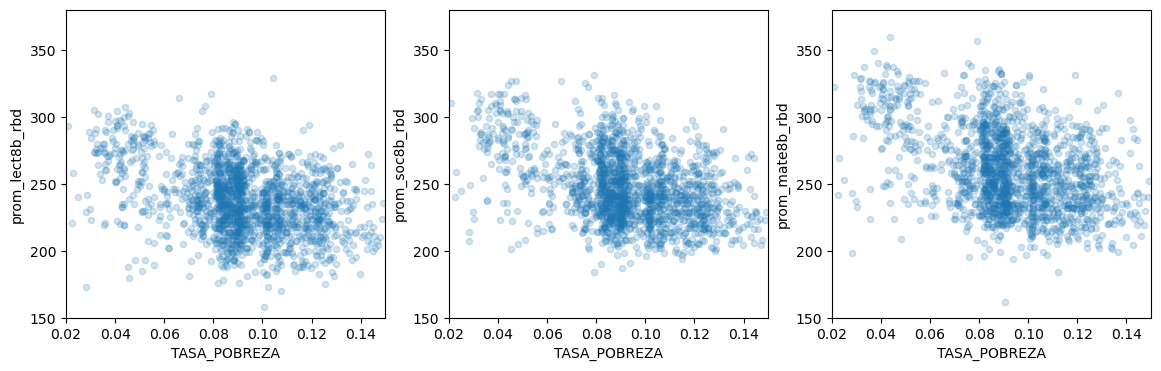

In [86]:
fig, ax = plt.subplots(1,len(pruebas_simce), figsize=(14,4))
xmin = 0.02
xmax = 0.15


for idx, col in enumerate(pruebas_simce):
    simce_pobreza.plot.scatter('TASA_POBREZA', col, ax=ax[idx], alpha=0.2)
    ax[idx].set_xlim(xmin, xmax)
    ax[idx].set_ylim(150, 380)
    
plt.show()

Ahí se ve algo interesante (y lamentablemente esperable)... ¿hay algun tipo de relación? Tratemos de ajustar un modelo lineal para ver que sale. Para eso ocuparemos el paquete `scipy`.

In [87]:
import scipy as sp

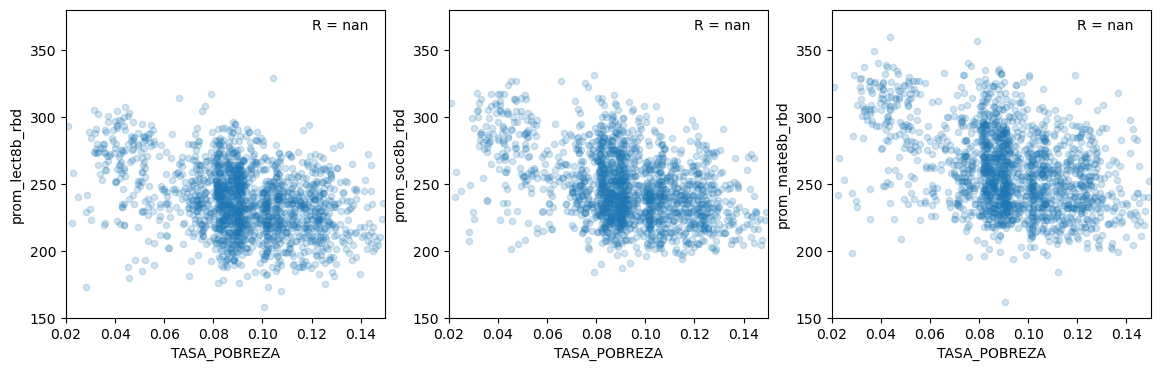

In [88]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
xmin = 0.02
xmax = 0.15

for idx, col in enumerate(['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']):
    simce_pobreza.plot.scatter('TASA_POBREZA', col, ax=ax[idx], alpha=0.2)
    b, a, r, p, std = sp.stats.linregress(simce_pobreza['TASA_POBREZA'], simce_pobreza[col])
    x = np.linspace(xmin, xmax, 100)
    ax[idx].plot(x, a + b * x, color='#984ea3', lw=1.5)
    ax[idx].text(0.12, 365, 'R = {:.2f}'.format(r))
    ax[idx].set_xlim(xmin, xmax)
    ax[idx].set_ylim(150, 380)
    
plt.show()

La línea no se ve porque hay `nan` dentro del dataframe, así que nos tenemos que deshacer de ellos para que funcione.

In [89]:
simce_pobreza_clean = simce_pobreza.dropna().sort_values(by='TASA_POBREZA')

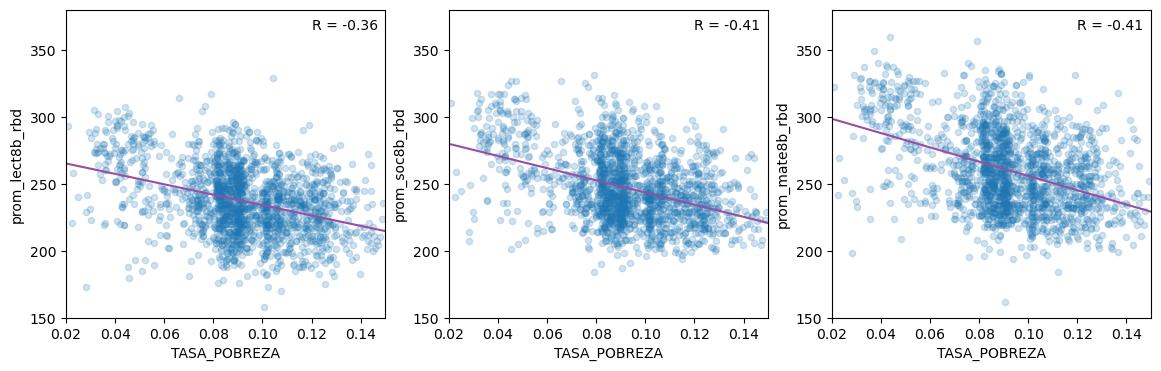

In [90]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
xmin = 0.02
xmax = 0.15

for idx, col in enumerate(['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']):
    simce_pobreza_clean.plot.scatter('TASA_POBREZA', col, ax=ax[idx], alpha=0.2)
    b, a, r, p, std = sp.stats.linregress(simce_pobreza_clean['TASA_POBREZA'], simce_pobreza_clean[col])
    x = np.linspace(xmin, xmax, 100)
    ax[idx].plot(x, a + b * x, color='#984ea3', lw=1.5)
    ax[idx].text(0.12, 365, 'R = {:.2f}'.format(r))
    ax[idx].set_xlim(xmin, xmax)
    ax[idx].set_ylim(150, 380)
    
plt.show()

Ahora, sería interesante hacer este mismo gráfico pero diferenciado por tipo de subvención.

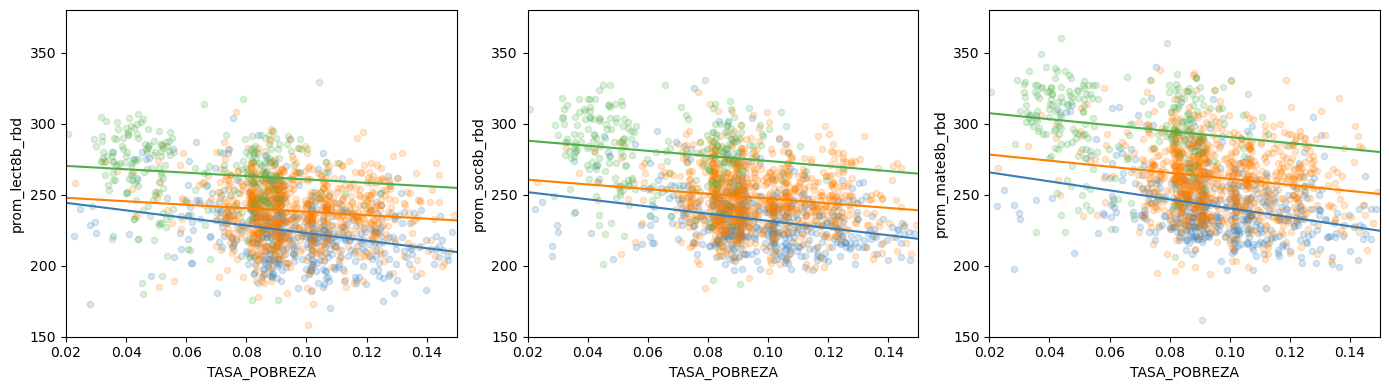

In [91]:
labels = ['Municipal', 'Particular Subvencionado', 'Particular Pagado']
pruebas_simce = ['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']

fig, ax = plt.subplots(1, len(pruebas_simce), figsize=(14,4))
xmin = 0.02
xmax = 0.15

for idx, col in enumerate(pruebas_simce):
    for depe, label in enumerate(labels):
        depe_simce = simce_pobreza_clean[simce_pobreza_clean['COD_DEPE2'] == depe + 1]
        depe_simce.plot.scatter('TASA_POBREZA', col, ax=ax[idx], alpha=0.2, color=colors[depe])
        
        b, a, r, p, std = sp.stats.linregress(depe_simce['TASA_POBREZA'], depe_simce[col])
        x = np.linspace(xmin, xmax, 100)
        ax[idx].plot(x, a + b * x, color=colors[depe], lw=1.5)

        ax[idx].set_xlim(xmin, xmax)
        ax[idx].set_ylim(150, 380)

fig.tight_layout()
plt.show()

Y sería mejor aún si los separamos en distintos gráficos para ver todo más claramente.

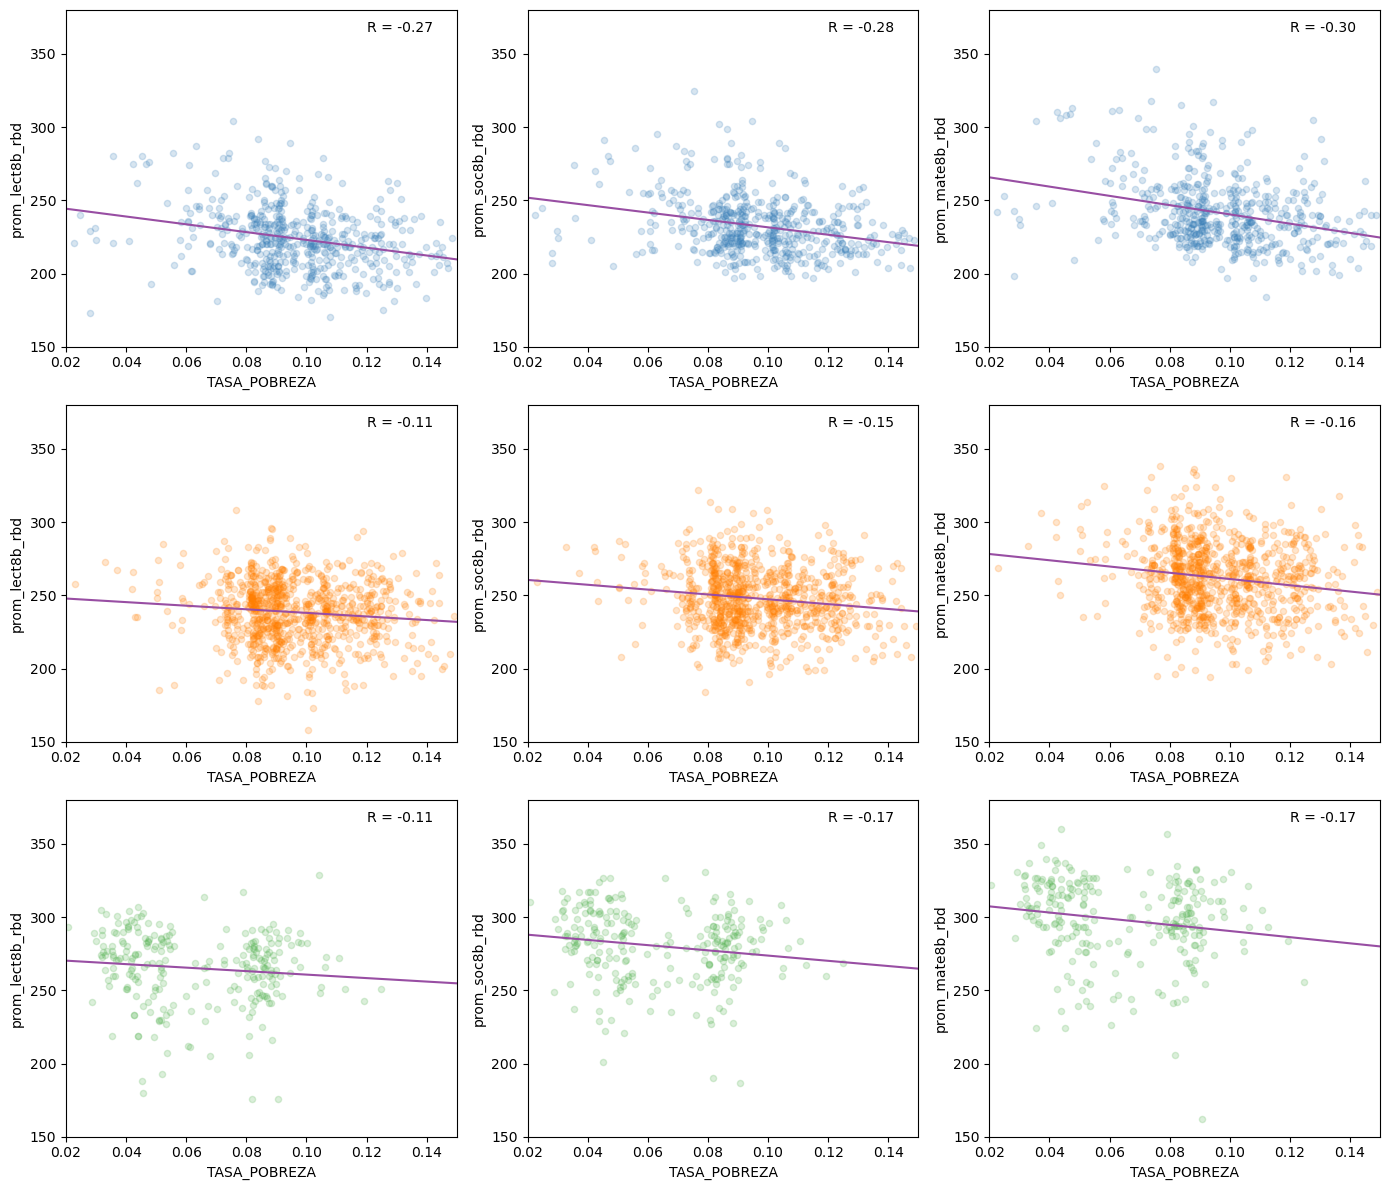

In [92]:
labels = ['Municipal', 'Particular Subvencionado', 'Particular Pagado']
pruebas_simce = ['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']

fig, ax = plt.subplots(len(labels), len(pruebas_simce), figsize=(14,12))
xmin = 0.02
xmax = 0.15

for depe, label in enumerate(labels):
    for idx, col in enumerate(pruebas_simce):
        depe_simce = simce_pobreza_clean[simce_pobreza_clean['COD_DEPE2'] == depe + 1]
        depe_simce.plot.scatter('TASA_POBREZA', col, ax=ax[depe][idx], alpha=0.2, color=colors[depe])
        b, a, r, p, std = sp.stats.linregress(depe_simce['TASA_POBREZA'], depe_simce[col])
        x = np.linspace(xmin, xmax, 100)
        ax[depe][idx].plot(x, a + b * x, color='#984ea3', lw=1.5)
        ax[depe][idx].text(0.12, 365, 'R = {:.2f}'.format(r))
        ax[depe][idx].set_xlim(xmin, xmax)
        ax[depe][idx].set_ylim(150, 380)

fig.tight_layout()
plt.show()

Recién ahora me dí cuenta de algo que no hemos considerado: el total de estudiantes por establecimiento.

In [93]:
n_total = (
    df_rm.groupby(['RBD'])
        .agg(n_total=('COD_COM_ALU', 'count'))
        .reset_index()
)

n_total.head()

,RBD,n_total
0,8485,3612
1,8487,2559
2,8488,398
3,8489,442
4,8490,476


Y lo mezclamos con nuestro dataframe.

In [94]:
simce_pobreza_total = simce_pobreza_clean.merge(n_total).dropna()
simce_pobreza_total.head()

,RBD,TASA_POBREZA,NOM_RBD,COD_DEPE2,prom_lect8b_rbd,prom_soc8b_rbd,prom_mate8b_rbd,n_total
0,10574,0.017128,ESCUELA ESPANA,1,201.0,212.0,222.0,143
1,8904,0.020667,COLEGIO SANTA URSULA,3,293.0,310.0,322.0,769
2,9996,0.022519,ESCUELA ESPANA,1,221.0,240.0,242.0,214
3,24954,0.022953,COLEGIO EL REDENTOR,2,258.0,259.0,269.0,352
4,10760,0.024746,ESCUELA REPUBLICA DE ISRAEL,1,240.0,245.0,253.0,223


Lamentablemente el método de `scipy` que ocupamos para ajustar el model lineal no acepta pesos como parámetros, por lo que tenemos que ocupar otro paquete llamado `sklearn`.

In [95]:
from sklearn.linear_model import LinearRegression

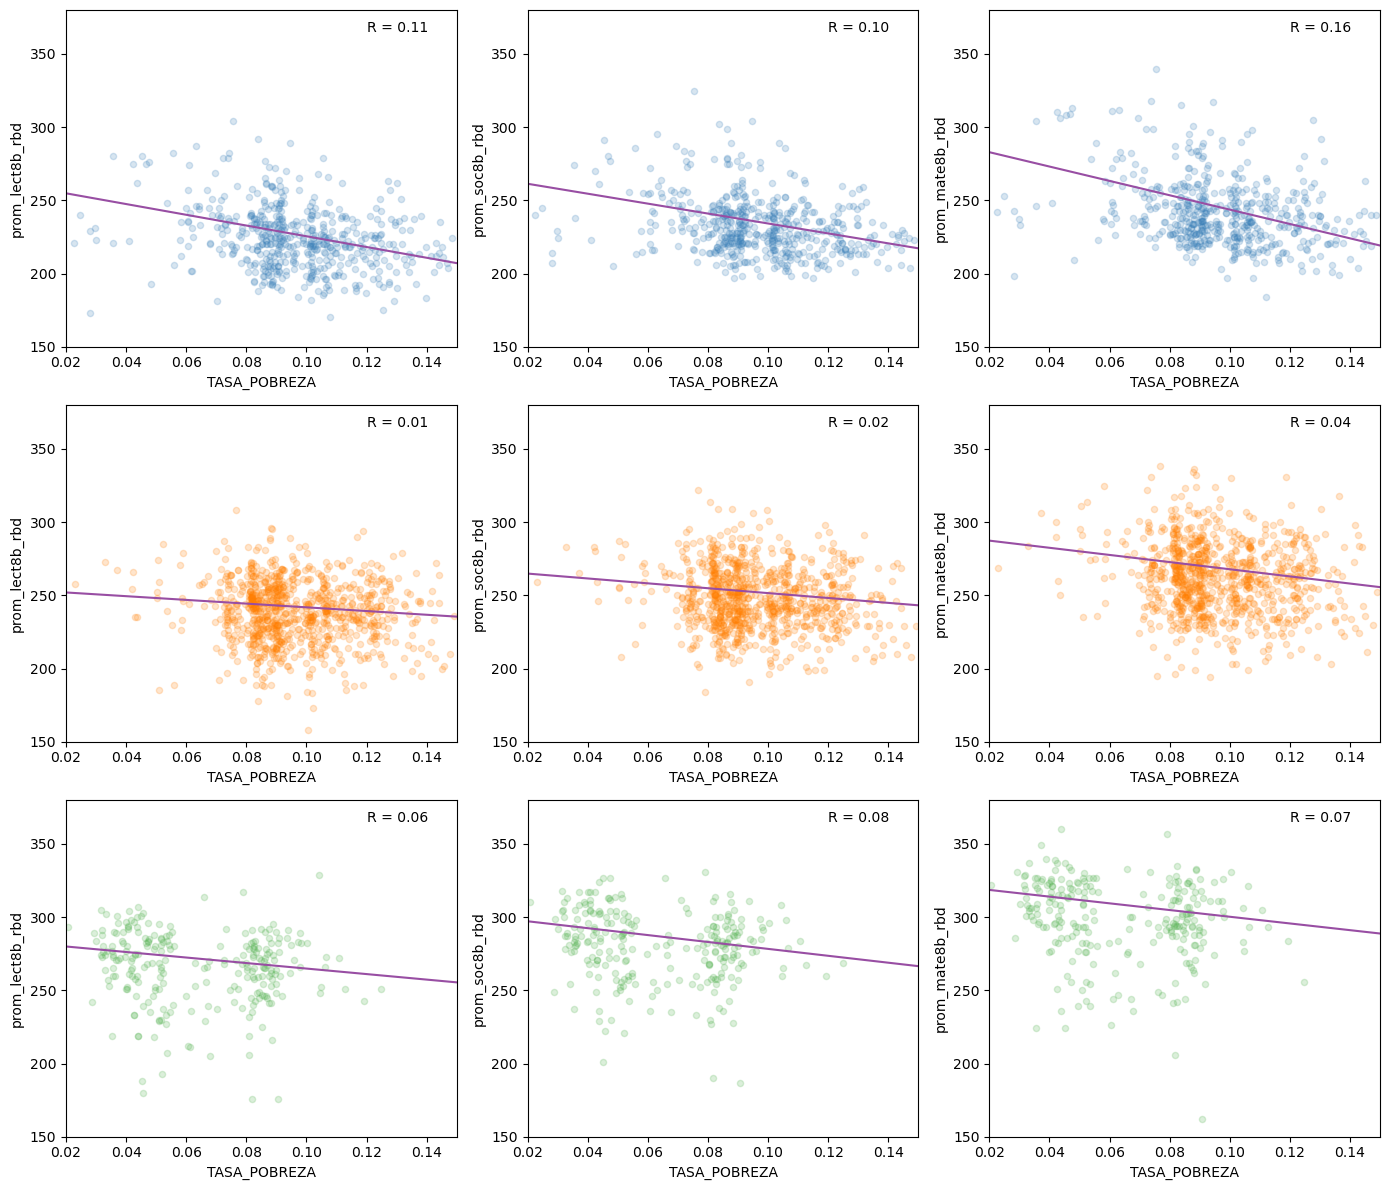

In [97]:
labels = ['Municipal', 'Particular Subvencionado', 'Particular Pagado']
pruebas_simce = ['prom_lect8b_rbd', 'prom_soc8b_rbd', 'prom_mate8b_rbd']

fig, ax = plt.subplots(len(labels), len(pruebas_simce), figsize=(14,12))
xmin = 0.02
xmax = 0.15

for depe, label in enumerate(labels):
    for idx, col in enumerate(pruebas_simce):
        depe_simce = simce_pobreza_total[simce_pobreza_total['COD_DEPE2'] == depe + 1]
        depe_simce.plot.scatter('TASA_POBREZA', col, ax=ax[depe][idx], alpha=0.2, color=colors[depe])
        
        linreg = LinearRegression()
        linreg.fit(depe_simce[['TASA_POBREZA']], depe_simce[[col]], depe_simce['n_total'].to_numpy())
        r = linreg.score(depe_simce[['TASA_POBREZA']], depe_simce[[col]], depe_simce['n_total'].to_numpy())
        x = pd.DataFrame(np.linspace(xmin, xmax, 100), columns=['TASA_POBREZA'])
        x['prediction'] = linreg.predict(x[['TASA_POBREZA']])
        x.plot(x='TASA_POBREZA', y='prediction', color='#984ea3', lw=1.5, ax=ax[depe][idx], legend=False)
        ax[depe][idx].text(0.12, 365, 'R = {:.2f}'.format(r))
        ax[depe][idx].set_xlim(xmin, xmax)
        ax[depe][idx].set_ylim(150, 380)

fig.tight_layout()
plt.show()

Hasta acá ya tenemos todo lo necesario para armar una historia, con una narrativa clara y una intención de qué es lo que queremos comunicar. Ahora hay que pasar harto tiempo mejorando los gráficos para que se ven mejor.